In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold ,cross_validate


In [2]:
df=pd.read_csv('../Data/HouseImformation.csv')

In [3]:
df['Area'] = df['Area'].str.replace(',', '').astype(float)

df=df.dropna()

isoOuter=IsolationForest(contamination=0.01)
df['OuterData']=isoOuter.fit_predict(df[["Area", "Price"]])

df=df.drop(index=df[df['OuterData'] == -1].index)

MeanPriceAddressOuter=df.groupby("Address")["Price"].mean()
df["MeanPriceA"] = df["Address"].map(MeanPriceAddressOuter)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_Data = scaler.fit_transform(df[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_Data=df['Price'].values


In [5]:
mask= np.random.rand(len(df)) < 0.8

train=df[mask]
test=df[~mask]

x_train=np.asanyarray(train[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_train=np.asanyarray(train['Price'])

x_test=np.asanyarray(test[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_test=np.asanyarray(test['Price'])

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

##If I Increase learning rate Mean=>Decrease
#for n_estimators 150 is the Best Mean And Standard deviation
model=GradientBoostingRegressor(n_estimators=150,max_depth=3,learning_rate=0.1)

cv=RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)

CrossVal=cross_validate(model,x_Data,y_Data,cv=cv,scoring='r2',return_train_score=True)

print("Train Scores:", CrossVal['train_score'])
print("Mean Train Score:", CrossVal['train_score'].mean())

print("Test Scores:", CrossVal['test_score'])
print("Mean Test Score:", CrossVal['test_score'].mean())




Train Scores: [0.92503832 0.92155014 0.9275239  0.92532266 0.92615945 0.92818292
 0.92720826 0.92604302 0.92427269 0.92504705 0.92460833 0.9276184
 0.92427314 0.92511383 0.92554122 0.92281334 0.92530522 0.92793946
 0.92524961 0.9220807  0.91804594 0.9274897  0.92526509 0.92230127
 0.92688312 0.92662993 0.92430124 0.92932868 0.92521473 0.92661383]
Mean Train Score: 0.92529884020238
Test Scores: [0.84677246 0.87984441 0.81681065 0.86798604 0.88259954 0.84989013
 0.86483128 0.86493683 0.86585579 0.89315684 0.85741093 0.83845963
 0.87920233 0.86913133 0.86335107 0.87025039 0.8625196  0.84214449
 0.82926613 0.91809566 0.92346906 0.85349934 0.84374538 0.86724244
 0.87644846 0.88842451 0.89125425 0.82306691 0.89362732 0.83729927]
Mean Test Score: 0.8653530815422794


In [7]:
modelFit=GradientBoostingRegressor(n_estimators=100,max_depth=3,learning_rate=0.1)


modelFit.fit(x_train,y_train)

y_predict=modelFit.predict(x_test)
y_train_predict=modelFit.predict(x_train)

from sklearn.metrics import r2_score
print(f"Test R2 Score: {r2_score(y_test, y_predict):.2f}")
print(f"Train R2 Score: {r2_score(y_train, y_train_predict):.2f}")

Test R2 Score: 0.85
Train R2 Score: 0.92


In [8]:
joblib.dump(modelFit, '../Models/GradientBoostingRegressorModel.pkl')

['../Models/GradientBoostingRegressorModel.pkl']

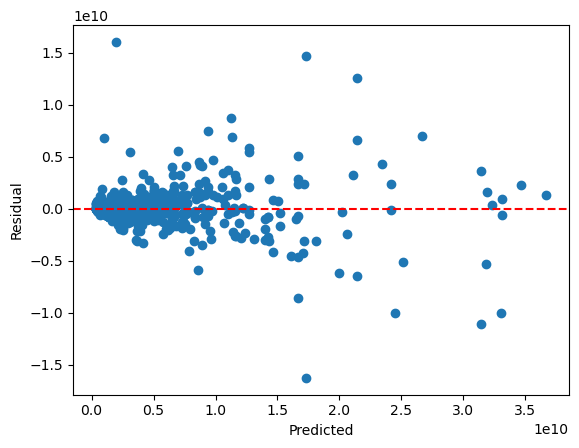

In [8]:
residuals = y_test - y_predict
plt.scatter(y_predict, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error

print("MAE:", mean_absolute_error(y_test, y_predict))

MAE: 1129464944.5732625


In [ ]:
from sklearn.linear_model import ElasticNet

pip=Pipeline([
    ('scale',StandardScaler()),
    ('poly',PolynomialFeatures(degree=2)),
    ('GradientBoostingRegressor',GradientBoostingRegressor(n_estimators=100,max_depth=3,learning_rate=0.1))
])
cvpip=RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)

CrossValpip=cross_validate(pip,x_Data,y_Data,cv=cvpip,scoring='r2',return_train_score=True)

print("Mean Train Score:", CrossValpip['train_score'].mean())

print("Mean Test Score:", CrossValpip['test_score'].mean())


Train Scores: [0.93277794 0.9329019  0.93240781 0.93563028 0.93351836 0.93413652
 0.93321909 0.92881264 0.92978165 0.93187258 0.93212586 0.93238631
 0.9313046  0.93446715 0.93242878 0.9315945  0.9315516  0.93361068
 0.93359657 0.93135385 0.928399   0.93715235 0.93637031 0.92913803
 0.93115145 0.93062249 0.93334423 0.93425497 0.93143606 0.93206816]
Mean Train Score: 0.9324471914161376
Test Scores: [0.83732659 0.8683577  0.82715442 0.85076368 0.86843516 0.85647043
 0.88064812 0.87391583 0.87695253 0.89185457 0.8736029  0.82823366
 0.89845251 0.84966572 0.85028709 0.8868832  0.87265077 0.85605244
 0.83120444 0.89237208 0.92635622 0.84107317 0.82832672 0.86168733
 0.87934557 0.89491188 0.89464345 0.83938388 0.87951587 0.88063267]
Mean Test Score: 0.866572019682707


In [11]:
pip.fit(x_train,y_train)

y_predict=pip.predict(x_test)
y_train_predict=pip.predict(x_train)

from sklearn.metrics import r2_score
print(f"Test R2 Score: {r2_score(y_test, y_predict):.2f}")
print(f"Train R2 Score: {r2_score(y_train, y_train_predict):.2f}")

Test R2 Score: 0.83
Train R2 Score: 0.94


In [12]:
joblib.dump(pip, '../Models/GradientBoostingRegressorWithPolynomialFeaturesModel.pkl')

['../Models/GradientBoostingRegressorWithPolynomialFeaturesModel.pkl']

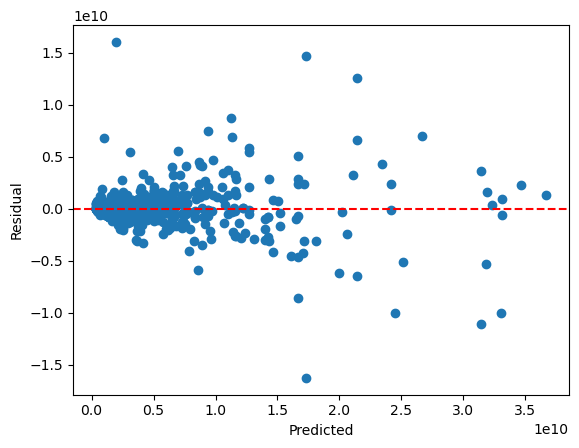

MAE: 1012925841.9239452


In [14]:
residuals = y_test - y_predict
plt.scatter(y_predict, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

from sklearn.metrics import mean_absolute_error

print("MAE:", mean_absolute_error(y_test, y_predict))

<h3>By removing ~10% of samples detected as outliers using Isolation Forest, the MAE dropped significantly from ~1 billion IRR to ~575 million IRR in Gradient Boosting Regression.</h3>

In [10]:
isoOuter10=IsolationForest(contamination=0.1)
df['OuterData10']=isoOuter10.fit_predict(df[["Area", "Price"]])

df=df.drop(index=df[df['OuterData10'] == -1].index)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_Data = scaler.fit_transform(df[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_Data=df['Price'].values

In [12]:
mask= np.random.rand(len(df)) < 0.8

train=df[mask]
test=df[~mask]

x_train=np.asanyarray(train[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_train=np.asanyarray(train['Price'])

x_test=np.asanyarray(test[['Area','Room','Parking','Warehouse','Elevator','MeanPriceA']])
y_test=np.asanyarray(test['Price'])

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

##If I Increase learning rate Mean=>Decrease
#for n_estimators 150 is the Best Mean And Standard deviation
model=GradientBoostingRegressor(n_estimators=150,max_depth=3,learning_rate=0.1)

cv=RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)

CrossVal=cross_validate(model,x_Data,y_Data,cv=cv,scoring='r2',return_train_score=True)

print("Train Scores:", CrossVal['train_score'])
print("Mean Train Score:", CrossVal['train_score'].mean())

print("Test Scores:", CrossVal['test_score'])
print("Mean Test Score:", CrossVal['test_score'].mean())


Train Scores: [0.92087818 0.92054786 0.91855236 0.9208255  0.91686692 0.92013078
 0.91862874 0.92493638 0.92049216 0.92052346 0.92201424 0.92211478
 0.92465767 0.91928773 0.91899141 0.91844135 0.91838709 0.92018494
 0.91891736 0.91708184 0.92097508 0.92117285 0.92014041 0.91977981
 0.91942531 0.92067704 0.91926689 0.92053659 0.92228082 0.91841023]
Mean Train Score: 0.9201708596817159
Test Scores: [0.88146601 0.88699821 0.89752417 0.88403161 0.92315286 0.89233256
 0.91746858 0.85068265 0.89942056 0.88689304 0.87453164 0.86517192
 0.83932907 0.90122563 0.90701145 0.89877363 0.90909521 0.88511096
 0.89796111 0.91441783 0.87876805 0.87789649 0.8967222  0.90109861
 0.8992469  0.88489103 0.90525276 0.89615644 0.85405225 0.90192019]
Mean Test Score: 0.8902867876286866


In [14]:
modelFit=GradientBoostingRegressor(n_estimators=100,max_depth=3,learning_rate=0.1)


modelFit.fit(x_train,y_train)

y_predict=modelFit.predict(x_test)
y_train_predict=modelFit.predict(x_train)

from sklearn.metrics import r2_score
print(f"Test R2 Score: {r2_score(y_test, y_predict):.2f}")
print(f"Train R2 Score: {r2_score(y_train, y_train_predict):.2f}")

Test R2 Score: 0.89
Train R2 Score: 0.91


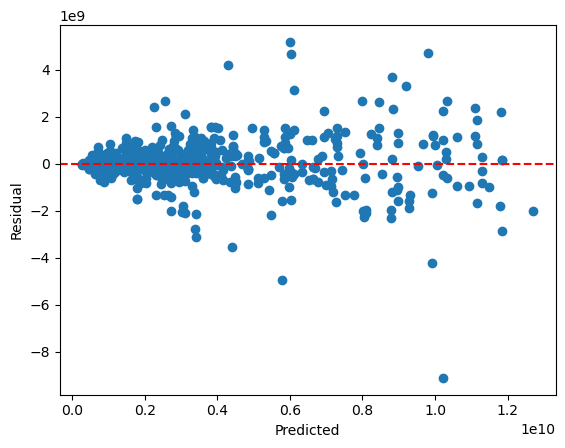

In [15]:
residuals = y_test - y_predict
plt.scatter(y_predict, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error

print("MAE:", mean_absolute_error(y_test, y_predict))

MAE: 575572515.8867165
